<a href="https://colab.research.google.com/github/ahoorarstmn/Pytorch_DL_FaraDars/blob/main/PyTorch_Residual_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm, trange
import numpy as np
from torchvision.datasets.utils import download_and_extract_archive

# **Data Retrieval**


## **Downloading from source**

`download_and_extract_archive` and `download_url` from `torch.datasets.utils`:

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_and_extract_archive(dataset_url, download_root="./data")

print(os.listdir("./data/cifar10/train"))
print(os.listdir("./data/cifar10/test"))

  0%|          | 0/135107811 [00:00<?, ?it/s]

Extracting ./data/cifar10.tgz to ./data
['deer', 'horse', 'bird', 'automobile', 'airplane', 'ship', 'frog', 'cat', 'dog', 'truck']
['deer', 'horse', 'bird', 'automobile', 'airplane', 'ship', 'frog', 'cat', 'dog', 'truck']


In [ ]:
mean_std_values = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transform = transforms.Compose([transforms.RandomCrop(32),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.AugMix(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(*mean_std_values, inplace=True)])

val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(*mean_std_values)])

## **ImageFolder Class**
* Generic data loader.
* Arrangement of the folder:
    * root/dog/xxx.png
    * root/dog/xxy.png
    * root/dog/[...]/xxz.png

    * root/cat/123.png
    * root/cat/nsdf3.png
    * root/cat/[...]/asd932_.png

In [ ]:
train_set = ImageFolder("./data/cifar10/", train_transform)
valid_set = ImageFolder("./data/cifar10/", val_transform)

In [ ]:
batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

## **Vanishing Gradient**


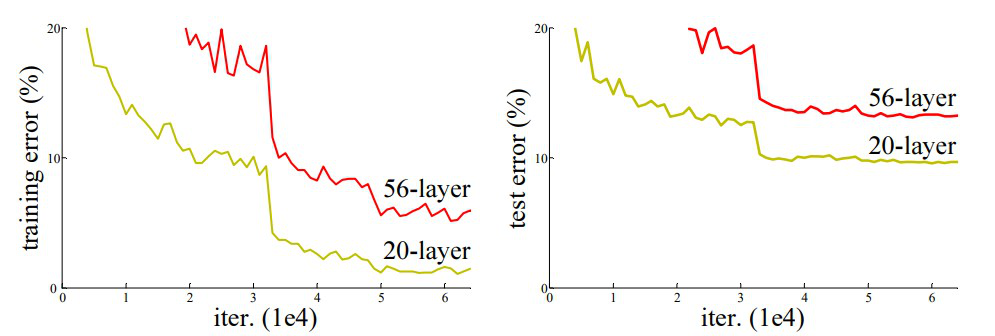

# **Residual Networks**


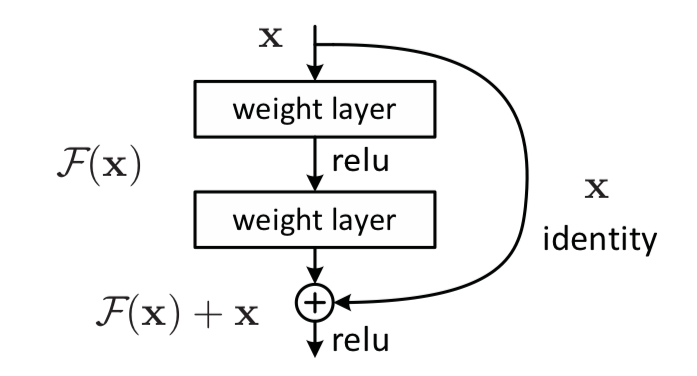

## **ResNet9**




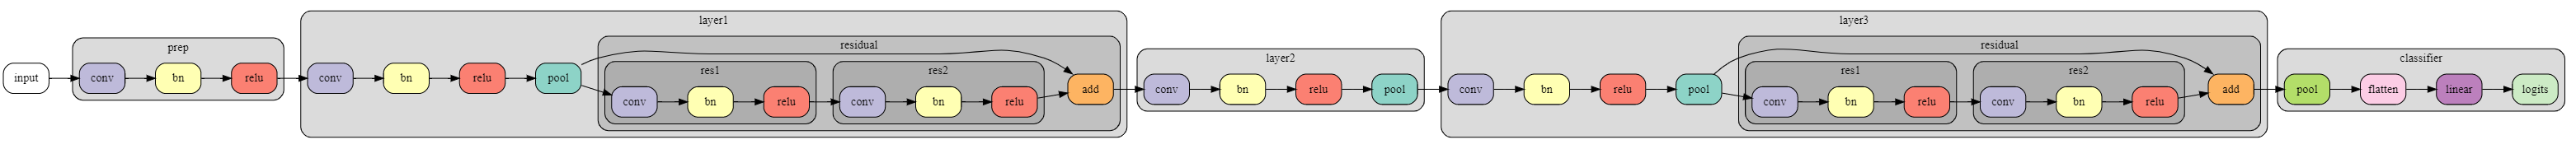

In [ ]:
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet9, self).__init__()

        self.conv1 = self._make_conv_block(in_channels, 64)
        self.conv2 = self._make_conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(self._make_conv_block(128, 128), self._make_conv_block(128, 128))

        self.conv3 = self._make_conv_block(128, 256, pool=True)
        self.conv4 = self._make_conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self._make_conv_block(512, 512), self._make_conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def _make_conv_block(self, in_channels, out_channels, pool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.classifier(x)
        return x


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet9(3, 10).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **Training Loop**


In [ ]:
def calculate_accuracy(pred, y):
    top_pred = pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, dataloader, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for features, labels in tqdm(dataloader, desc="Training Phase", leave=False):
        # Sending features and labels to device
        features = features.to(device)
        labels = labels.to(device)

        # Forward pass; making predictions and calculating loss
        pred = model(features)
        loss = criterion(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculating accuracies
        acc = calculate_accuracy(pred, labels)
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for features, labels in tqdm(dataloader, desc="Evaluation Phase", leave=False):

            features = features.to(device)
            labels = labels.to(device)

            pred = model(features)

            loss = criterion(pred, labels)

            acc = calculate_accuracy(pred, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
EPOCHS = 2

history = {
    'train_loss': [],
    'train_acc': [], 
    'val_loss': [],
    'val_acc': []
}

for epoch in trange(EPOCHS, desc="Epoch Number"):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    history['val_loss'].append(valid_loss)
    history['val_acc'].append(valid_acc)

    print(f"Epoch: [{epoch+1:02}]")
    print(f"\tTraining Loss: {train_loss:>7.3f} | Training Accuracy: {train_acc*100:>7.2f}%")
    print(f"\tValidation Loss: {valid_loss:>.3f} | Validation Accuracy: {valid_acc*100:>7.2f}%")


Epoch Number:   0%|          | 0/2 [00:00<?, ?it/s]

Training Phase:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [01]
	Training Loss:   0.503 | Training Accuracy:   82.42%
	Validation Loss: 0.465 | Validation Accuracy:   83.38%


Training Phase:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [02]
	Training Loss:   0.473 | Training Accuracy:   82.93%
	Validation Loss: 0.454 | Validation Accuracy:   83.38%
